#### Importing libraries

In [31]:
import numpy as np
from scipy import spatial
from sklearn.neighbors import KNeighborsClassifier
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 200
batch_size = 256
data_size = 5000
verbose = True
Datapath='heloo'
dataset_path = '/content/drive/MyDrive/dataset/mnist_60000.npz'
dataset = np.load(dataset_path)
perm = np.random.permutation(len(dataset['data']))


# split data
X_train = dataset['data'][perm][:data_size]
y_train = dataset['target'][perm][:data_size]
X_test = dataset['data'][perm][data_size:data_size * 2]
y_test = dataset['target'][perm][data_size:data_size * 2]

In [32]:
# import pandas as pd
# import numpy as np
# train_df = np.load("/content/drive/MyDrive/MNIST Dataset/resnet_mnist.npz")
# X_train = train_df['X_train'][:5000]
# y_train = train_df['y_train'][:5000]
# X_test = train_df['X_test'][:5000]
# y_test = train_df['y_test'][:5000]

In [33]:
X_train.shape

(5000, 784)

## Let's define our architecture

In [34]:
!pip install openTSNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import operator
from functools import reduce

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

def get_activation(act, inplace=True):
	if act == 'lrelu':
		return nn.LeakyReLU(0.01, inplace=inplace)
	elif act == 'relu':
		return nn.ReLU(inplace=inplace)
	elif act == 'sigmoid':
		return nn.Sigmoid()
	raise Exception('unsupported activation function')

class FCEncoder(nn.Module):
	def __init__(self, dim, low_dim=2, act='lrelu'):
		super(FCEncoder, self).__init__()
		self.dim = dim
		self.act = partial(get_activation, act=act)
        
		# new network (1024 -> 512 -> 256 -> 128 -> 2)
		# new network (784 -> 392 -> 146 -> 73 -> 2)
		layers = [
			(nn.Linear(dim, 1024)),
			# (nn.BatchNorm1d(1024)),
# 			(nn.Linear(dim, 784)),            
			self.act(),
			(nn.Linear(1024, 512)),
			# (nn.BatchNorm1d(512)),
# 			(nn.Linear(dim, 392)),
			self.act(),
			(nn.Linear(512, 256)),
			# (nn.BatchNorm1d(256)),
# 			(nn.Linear(dim, 146)),            
			self.act(),
			(nn.Linear(256, 128)),
			# (nn.BatchNorm1d(128)),
# 			(nn.Linear(dim, 73)),            
			self.act(),
			(nn.Linear(128, low_dim))
		]
        
		self.net = nn.Sequential(*layers)
		
	def forward(self, X):
		return self.net(X)


## Let's call our TSNE_NN

In [36]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from openTSNE import TSNE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from scipy.sparse import save_npz, load_npz
import random
from functools import partial
import timeit
import math
from tqdm import tqdm


EPS = 1e-12
D_GRAD_CLIP = 1e14

class TSNE_NN():
	def __init__(self, device, n_epochs ,hidden_dim=256, n_components=2, verbose=True, batch_size=256):
		self.device = device
		self.n_epochs = n_epochs
		self.batch_size = batch_size
		self.perplexity = 20
		self.test_data = None
		self.max_grads = []
		self.epoch_losses = []
		self.verbose = verbose
		self.hidden_dim = hidden_dim
		self.n_components = n_components
	
	def fit(self, data):
		self.encoder = FCEncoder(data.shape[1], low_dim=self.n_components)
		batch_size = self.batch_size
		print('perplexity:', self.perplexity)
		
		print('calc P')
		pre_embedding = TSNE(perplexity=self.perplexity).prepare_initial(data)
		P_csc = pre_embedding.affinities.P
			
		print('Trying to put X into GPU')
		X = torch.from_numpy(data).float()
		X = X.to(self.device)
		self.X = X

		self.encoder = self.encoder.to(self.device)
		init_lr = 1e-3
		optimizer = optim.Adam(self.encoder.parameters(), lr=init_lr)
		# optimizer = optim.AdamW(self.encoder.parameters(), lr=init_lr)
		# init_lr = 1e-3
		# optimizer = optim.SGD(self.encoder.parameters(), lr=init_lr, momentum=0.9, weight_decay=5e-4) 

		lr_sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs * math.ceil(len(X)/batch_size), eta_min=1e-7)
		
		def neg_squared_euc_dists(X):
			D = torch.cdist(X, X, p=2).pow(2)
			return -D

		def w_tsne(Y):
			distances = neg_squared_euc_dists(Y)
			inv_distances = 1. / (1. - (distances)) #1 / (1+d^2)
			return inv_distances
		
		def KLD(P, Q):
			x = P/Q
			if x.requires_grad:
				def hook(grad):
					self.max_grads.append(float(grad.abs().max().cpu().numpy()))
					clipped_grad = grad.clamp(min=-D_GRAD_CLIP, max=D_GRAD_CLIP)
					return clipped_grad
				x.register_hook(hook)
			return P * torch.log(x)
		
		iteration = 0
		print('optimizing...')
		pbar = tqdm(range(self.n_epochs))
		for epoch in pbar:
			iteration += 1

			idxs = torch.randperm(len(X))
			
			loss_total = []
			update_time = []
			for i in range(0, len(X), batch_size):
				start_time = timeit.default_timer()
				idx = idxs[i:i+batch_size]
				_p = torch.Tensor(P_csc[idx][:, idx].toarray()).float()
				if iteration < 250:
					_p *= 4
				p = (_p+EPS).to(self.device)
				optimizer.zero_grad()
				y = self.encoder(X[idx])
				w = w_tsne(y)
				q = w / torch.sum(w)
				loss = KLD(p, q).sum()
				loss.backward()
				loss_total.append(loss.item())
				torch.nn.utils.clip_grad_value_(self.encoder.parameters(), 4)
				optimizer.step()
				elapsed = timeit.default_timer() - start_time
				update_time.append(elapsed)
			
				lr_sched.step()
			
			self.epoch_losses.append(np.mean(loss_total))
			if (self.verbose):
				pbar.set_description("Processing epoch %03d/%03d loss : %.5f time : %.5fs" % (epoch + 1, self.n_epochs, np.mean(loss_total), np.mean(update_time)))
				# print('{:03d}/{:03d}'.format(epoch, self.n_epochs), '{:.5f}'.format(np.mean(self.loss_total)), '{:.5f}s'.format(np.mean(update_time)))
	
		with torch.no_grad():
			result = self.encoder(self.X).detach().cpu().numpy()
        	# Normalize coordinates to [0, 1]    
			result_min, result_max = result.min(), result.max()
			result_norm = (result - result_min) / (result_max - result_min)
			return result_norm

	def fit_val(self, data):
		with torch.no_grad():
			self.X = torch.from_numpy(data).float()
			self.X = self.X.to(self.device)
			result = self.encoder(self.X).detach().cpu().numpy()
			# Normalize coordinates to [0, 1]    
			result_min, result_max = result.min(), result.max()
			result_norm = (result - result_min) / (result_max - result_min)
			return result_norm

# Let's us train and check

#### Applying PCA First

In [37]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components =2)
# X_pca = pca.fit_transform(X_test)
# # plt.scatter(X_pca[:,0],X_pca[:,1])
# scatter =plt.scatter(X_pca[:,0],X_pca[:,1],c=y_test,cmap='tab10')
# plt.legend(*scatter.legend_elements(), title='Classes')

#### Standard t-SNE 


In [38]:
# from sklearn.manifold import TSNE
# import time

# tsne = TSNE(n_components=2)
# start_time = time.time()
# x_tsne = tsne.fit_transform(X_test)
# end_time = time.time()
# # Compute the time taken to run the function
# print("Time taken:", end_time - start_time, "seconds")

# # scatter = plt.scatter(x_tsne[:,0],x_tsne[:,1],c=y_test,cmap='tab10')
# # plt.legend(*scatter.legend_elements(), title='Classes')

In [39]:
# Setting parameters(perplexity for TSNE, n_neighbors and min_dist for UMAP)
tsne_nn = TSNE_NN(device, n_epochs=epochs, verbose = verbose, batch_size=batch_size)

# Train
X_embedded = tsne_nn.fit(X_train)

perplexity: 20
calc P
Trying to put X into GPU
optimizing...


Processing epoch 200/200 loss : -0.02150 time : 0.00579s: 100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


In [40]:
import time
start_time = time.time()
X_embedded_test = tsne_nn.fit_val(X_test)
end_time = time.time()
# Compute the time taken to run the function
print("Time taken:", end_time - start_time, "seconds")

Time taken: 0.029326200485229492 seconds


In [41]:
X_embedded_test

array([[0.5880087 , 0.07033133],
       [0.85159564, 0.43427163],
       [0.870174  , 0.81642514],
       ...,
       [0.6970499 , 0.31364906],
       [0.42737386, 0.84255487],
       [0.40219206, 0.77785903]], dtype=float32)

Text(0.5, 1.0, 'MNIST dataset with 2048 features resnet50')

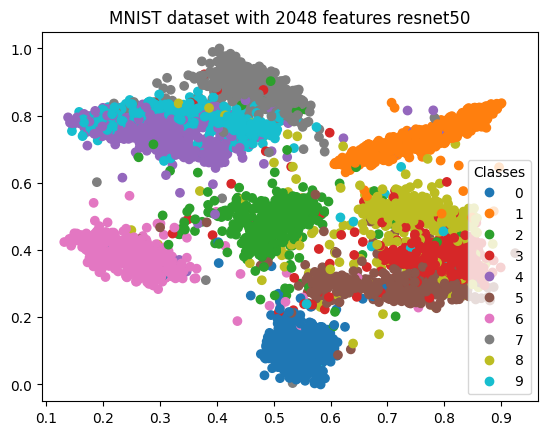

In [42]:
scatter = plt.scatter(X_embedded_test[:,0],X_embedded_test[:,1],c=y_test,cmap='tab10')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.title("MNIST dataset with 2048 features resnet50")


In [43]:
numbers =list(range(10))
import pandas as pd
df = pd.DataFrame({'x':X_embedded_test[:,0],'y':X_embedded_test[:,1],'label':y_test})
df =df.groupby('label').mean().reset_index()
df.head()

mean_position={}
for label in df.label:
    mean_position[str(label)]=[]
    mean_position[str(label)].append(df[df['label']==label]['x'].values[0])
    mean_position[str(label)].append(df[df['label']==label]['y'].values[0])
    


# Basically trying to find the number closest to it's number
from scipy.spatial import KDTree
import numpy as np
kdtree = KDTree(X_embedded_test)
def return_index_closest_point(mean_postion,label):
    x=mean_position[label][0]
    y=mean_position[label][1]
    d, i = kdtree.query((x,y))
    return i
images = {}

for i,y in enumerate(y_test):
    if y not in images.keys():
        index = return_index_closest_point(mean_position,str(y))
        if y_test[index]==y:
            images[str(y)] = X_test[index].reshape(28,28)
    if len(images.keys())>10:
        break
print(images.keys())
for i,num in enumerate(y_test):
  if not(num in images.keys()):
        images[str(num)] = X_test[i].reshape(28,28)
print(images.keys())

dict_keys(['0', '8', '1', '7', '5', '2', '6', '3', '9', '4'])
dict_keys(['0', '8', '1', '7', '5', '2', '6', '3', '9', '4'])


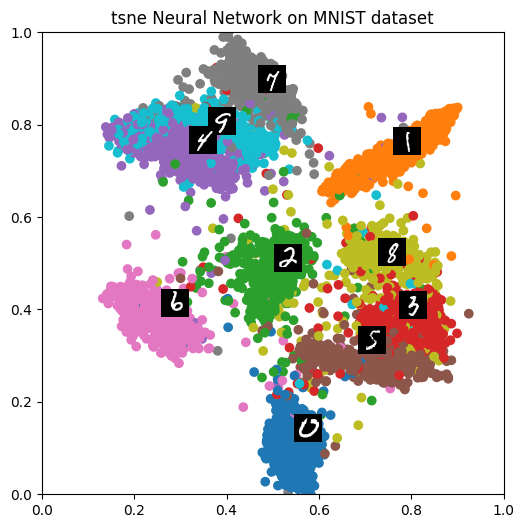

In [47]:

# Set the size of the plot in inches
fig = plt.figure(figsize=(6, 6))
plt.scatter(X_embedded_test[:,0],X_embedded_test[:,1],c=y_test,cmap='tab10')

for i in images.keys():
    x=mean_position[i][0]
    y=mean_position[i][1]
    plt.imshow(images[i], extent=[x , x+0.06, y, y+0.06],cmap='gray',zorder=10)

plt.title('tsne Neural Network on MNIST dataset')
# Set the axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


## Correctness

In [48]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier


def metric_continuity(D_high, D_low, k):
    assert D_high.shape == D_low.shape, 'D_high != D_low shape!'
    N_SAMPLES = D_high.shape[0]

    n = N_SAMPLES

    nn_orig = D_high.argsort()
    nn_proj = D_low.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(N_SAMPLES):
        V = np.setdiff1d(knn_orig[i], knn_proj[i])

        sum_j = 0
        for j in range(V.shape[0]):
            sum_j += np.where(nn_proj[i] == V[j])[0] - k

        sum_i += sum_j

    return float((1 - (2/(n*k*(2*n - 3*k - 1))*sum_i)).squeeze())

def metric_trustworthiness(D_high, D_low, k):
    assert D_high.shape == D_low.shape, 'D_high != D_low shape!'
    N_SAMPLES = D_high.shape[0]

    n = N_SAMPLES

    nn_orig = D_high.argsort()
    nn_proj = D_low.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        U = np.setdiff1d(knn_proj[i], knn_orig[i])

        sum_j = 0
        for j in range(U.shape[0]):
            sum_j += np.where(nn_orig[i] == U[j])[0] - k

        sum_i += sum_j

    return float((1 - (2/(n*k*(2*n - 3*k - 1))*sum_i)).squeeze())

def metric_neighborhood_hit(X, y, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    neighbors = knn.kneighbors(X, return_distance=False)
    return np.mean(np.mean((y[neighbors] == np.tile(y.reshape((-1, 1)), k)).astype('uint8'), axis=1))


In [49]:
#High dimension
D_high_list = spatial.distance.pdist(X_test, 'euclidean')   
D_high_matrix = spatial.distance.squareform(D_high_list)    

# low dimension data"
D_low_list = spatial.distance.pdist(X_embedded_test, 'euclidean')
# print("The low dimension list mein:",len(D_low_list))
D_low_matrix = spatial.distance.squareform(D_low_list)
print("The low dimension list mein:",D_low_matrix.shape)

print("----------Evaluation----------")
# Continuity
continuity = metric_continuity(D_high_matrix, D_low_matrix, k=7)
print("Continuity = " + str(continuity))
# Trustworthiness
trustworthiness = metric_trustworthiness(D_high_matrix, D_low_matrix, k=7)
print("Trustworthiness = " + str(trustworthiness))
# Neighborhood Hit
neighborhood_hit = metric_neighborhood_hit(X_embedded_test, y_test, k=7)
print("Neighborhood Hit = " + str(neighborhood_hit))
# Average
average = (continuity + trustworthiness + neighborhood_hit) / 3
print("Average = " + str(average))


The low dimension list mein: (5000, 5000)
----------Evaluation----------
Continuity = 0.9613644131374739
Trustworthiness = 0.9134757838673654
Neighborhood Hit = 0.8504571428571428
Average = 0.9084324466206608


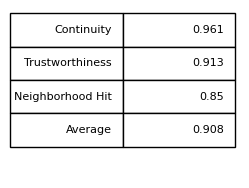

In [50]:
plt.subplot(224) 
table_data=[
    ["Continuity", round(continuity,3)],
    ["Trustworthiness", round(trustworthiness,3)],
    ["Neighborhood Hit", round(neighborhood_hit,3)],
    ["Average", round(average,3)]
]
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=table_data, loc='best')
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
the_table.scale(1, 2)


#I guess we found resnet

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.model_selection import train_test_split
X= iris.data
Y= iris.target
trainX,testX,trainY,testY = train_test_split(X,Y,test_size=0.2,random_state=0)
iris_trn_x = tsne_nn.fit(trainX) 
iris_tst_x_embd = tsne_nn.fit_val(testX)
fig = plt.figure(figsize=(4, 4))
scatter = plt.scatter(iris_tst_x_embd[:,0],iris_tst_x_embd[:,1],c=testY,cmap='tab10')
plt.legend(*scatter.legend_elements(), title='Flowers')


<ipython-input-40-90103d3b8449>:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(handles, labels, title='Flowers', labels=iris.target_names)


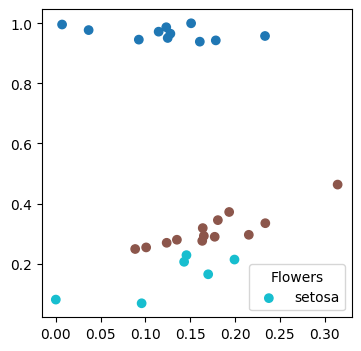

In [ ]:
from sklearn.model_selection import train_test_split

perplexity: 15
calc P
Trying to put X into GPU
optimizing...


Processing epoch 200/200 loss : 7.35897 time : 0.02508s: 100%|██████████| 200/200 [00:05<00:00, 36.46it/s]


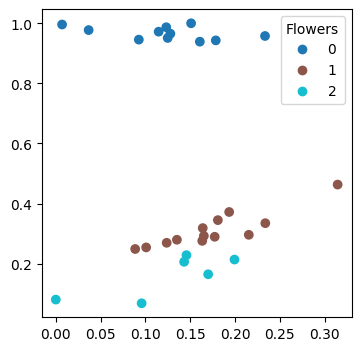

In [ ]:
fig = plt.figure(figsize=(4, 4))
scatter = plt.scatter(iris_tst_x_embd[:,0],iris_tst_x_embd[:,1],c=testY,cmap='tab10')
plt.legend(*scatter.legend_elements(), title='Flowers')
plt.show()

In [ ]:
#High dimension
D_high_list = spatial.distance.pdist(testX, 'euclidean')   
D_high_matrix = spatial.distance.squareform(D_high_list)    

# low dimension data"
D_low_list = spatial.distance.pdist(iris_tst_x_embd, 'euclidean')
# print("The low dimension list mein:",len(D_low_list))
D_low_matrix = spatial.distance.squareform(D_low_list)
print("The low dimension list mein:",D_low_matrix.shape)

print("----------Evaluation----------")
# Continuity
continuity = metric_continuity(D_high_matrix, D_low_matrix, k=7)
print("Continuity = " + str(continuity))
# Trustworthiness
trustworthiness = metric_trustworthiness(D_high_matrix, D_low_matrix, k=7)
print("Trustworthiness = " + str(trustworthiness))
# Neighborhood Hit
neighborhood_hit = metric_neighborhood_hit(X_embedded_test, y_test, k=7)
print("Neighborhood Hit = " + str(neighborhood_hit))
# Average
average = (continuity + trustworthiness + neighborhood_hit) / 3
print("Average = " + str(average))


The low dimension list mein: (30, 30)
----------Evaluation----------
Continuity = 0.987218045112782
Trustworthiness = 0.9854636591478697
Neighborhood Hit = 0.8442857142857141
Average = 0.9389891395154552


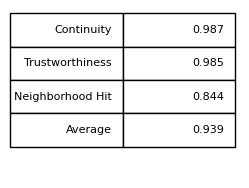

In [ ]:
plt.subplot(224) 
table_data=[
    ["Continuity", round(continuity,3)],
    ["Trustworthiness", round(trustworthiness,3)],
    ["Neighborhood Hit", round(neighborhood_hit,3)],
    ["Average", round(average,3)]
]
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=table_data, loc='best')
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
the_table.scale(1, 2)


Questoions to ask?
1) Why the neural network behaves differently in both the case?

2)Do i need to find the metric that you have given in research paper?

3) Do u want me to show all the data points by their images or this is fine?

(5000, 28, 28, 1)

## ATTEMPT FOR RESNET


In [ ]:
import cv2
import numpy as np

# Load your grayscale images
trainX_gray =  X_train.reshape(-1, 28, 28, 1) # shape: (5000, 28, 28, 1)
img_norm = cv2.normalize(trainX_gray, None, 0, 255, cv2.NORM_MINMAX)
img_8u = np.uint8(img_norm)
# Resize images to 224x224
trainX_gray = img_8u
trainX_resized = np.zeros((len(trainX_gray), 224, 224, 3))
for i in range(len(trainX_gray)):
    img = cv2.resize(trainX_gray[i], (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    trainX_resized[i] = img

# Normalize pixel values to [0, 1]
trainX_resized = trainX_resized / 255.0


NameError: ignored

In [ ]:
# from tensorflow import keras
# Convert grayscale images to RGB format
X_train_rgb = np.stack((X_train,)*3, axis=-1)

# Create ResNet50 model

from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features from trainX dataset
features = model.predict(X_train_rgb)





ValueError: ignored

## Preparing the dataset

In [ ]:
class MNISTDataset():
    def __init__(self, data_path, transform=None, data_size=None):
        self.data = np.load(data_path)['data'][:data_size]
        self.targets = np.load(data_path)['target'][:data_size]
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        # Reshape image to (1, 28, 28)
        image = image.reshape(1, 28, 28)
        
        return image, label

from torchvision.models import resnet18
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Initialize the ResNet model
model = resnet18(pretrained=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create the dataloaders
train_dataset = MNISTDataset('/content/drive/MyDrive/dataset/mnist_60000.npz', transform=train_transform, data_size=5000)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = MNISTDataset('/content/drive/MyDrive/dataset/mnist_60000.npz', transform=test_transform, data_size=5000)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

# # 10-d latent space, for comparison with non-variational auto-encoder
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
num_epochs = 5
# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Training ...
Epoch [1 / 5] average reconstruction error: 0.000000


ValueError: ignored